In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [15]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 64
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [16]:
# Invertible Convolutional Network (ICN) for Super-Resolution
class InvertibleConvLayer(nn.Module):
    def __init__(self, in_channels):
        super(InvertibleConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)

    def inverse(self, y):
        return nn.functional.conv2d(y, self.conv.weight.inverse(), stride=1, padding=1)


In [17]:
class ICN(nn.Module):
    def __init__(self, num_layers, in_channels):
        super(ICN, self).__init__()
        self.layers = nn.ModuleList([InvertibleConvLayer(in_channels) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def inverse(self, y):
        for layer in reversed(self.layers):
            y = layer.inverse(y)
        return y


In [18]:
# Function to create low-resolution images (downsampled)
def downsample(images, scale_factor=2):
    return nn.functional.interpolate(images, scale_factor=1/scale_factor, mode='bilinear', align_corners=False)


In [19]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        # Create low-resolution images
        low_res_images = downsample(images, scale_factor=2)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(low_res_images)
        
        # Upsample model output to match the high-resolution image dimensions
        output = nn.functional.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
        
        # Compute loss with the original high-resolution images
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/100], Loss: 0.0097
Epoch [2/100], Loss: 0.0097
Epoch [3/100], Loss: 0.0097
Epoch [4/100], Loss: 0.0096
Epoch [5/100], Loss: 0.0096
Epoch [6/100], Loss: 0.0096
Epoch [7/100], Loss: 0.0096
Epoch [8/100], Loss: 0.0096
Epoch [9/100], Loss: 0.0096
Epoch [10/100], Loss: 0.0096
Epoch [11/100], Loss: 0.0096
Epoch [12/100], Loss: 0.0095
Epoch [13/100], Loss: 0.0095
Epoch [14/100], Loss: 0.0095
Epoch [15/100], Loss: 0.0095
Epoch [16/100], Loss: 0.0095
Epoch [17/100], Loss: 0.0095
Epoch [18/100], Loss: 0.0095
Epoch [19/100], Loss: 0.0095
Epoch [20/100], Loss: 0.0095
Epoch [21/100], Loss: 0.0095
Epoch [22/100], Loss: 0.0095
Epoch [23/100], Loss: 0.0095
Epoch [24/100], Loss: 0.0095
Epoch [25/100], Loss: 0.0095
Epoch [26/100], Loss: 0.0095
Epoch [27/100], Loss: 0.0095
Epoch [28/100], Loss: 0.0095
Epoch [29/100], Loss: 0.0095
Epoch [30/100], Loss: 0.0095
Epoch [31/100], Loss: 0.0095
Epoch [32/100], Loss: 0.0095
Epoch [33/100], Loss: 0.0095
Epoch [34/100], Loss: 0.0095
Epoch [35/100], Loss: 0

In [20]:
# Function to test super-resolution and visualize results
def super_resolve_and_display(model, images):
    model.eval()
    with torch.no_grad():
        low_res_images = downsample(images, scale_factor=2)
        high_res_output = model(low_res_images)
    
    plt.figure(figsize=(12, 4))
    for i in range(len(images)):
        # Original high-res image
        plt.subplot(3, len(images), i + 1)
        plt.imshow((images[i].permute(1, 2, 0) + 1) / 2)
        plt.axis('off')
        
        # Low-res image
        plt.subplot(3, len(images), i + 1 + len(images))
        plt.imshow((low_res_images[i].permute(1, 2, 0) + 1) / 2)
        plt.axis('off')
        
        # Super-resolved image
        plt.subplot(3, len(images), i + 1 + 2 * len(images))
        plt.imshow((high_res_output[i].permute(1, 2, 0) + 1) / 2)
        plt.axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20954621..1.1507134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07370412..1.0875103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05490893..0.82846594].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024348259..1.0634073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008589387..0.8547827].


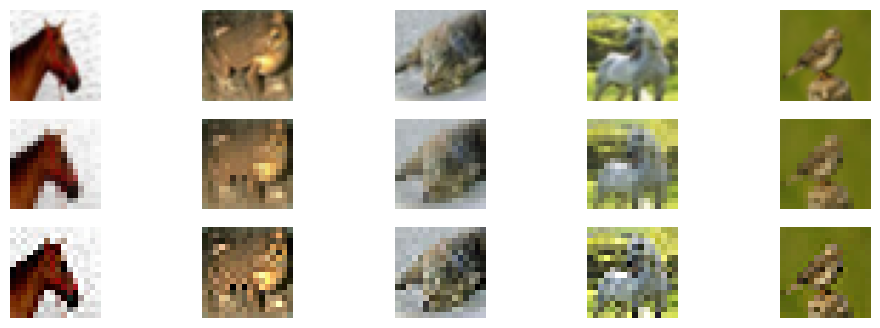

In [21]:
# Test and visualize the super-resolution model on some sample images
sample_images, _ = next(iter(train_loader))
super_resolve_and_display(model, sample_images[:5])
